In [ ]:
import pickle
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader
import time
import gzip
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
a = torch.rand(2,3)
print(a)

tensor([[0.2488, 0.0090, 0.9142],
        [0.9141, 0.7183, 0.0879]])


In [ ]:
# Dataset borrowed from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
class SentimentAnalysisDataset(torch.utils.data.Dataset):
    def __init__(self, train_or_test, dataset_file, path_to_saved_embeddings=None):
        super(SentimentAnalysisDataset, self).__init__()
        import gensim.downloader as gen_api
#                self.word_vectors = gen_api.load("word2vec-google-news-300")
        self.path_to_saved_embeddings = path_to_saved_embeddings
        self.train_or_test = train_or_test
        f = gzip.open(dataset_file, 'rb')
        dataset = f.read()
        if path_to_saved_embeddings is not None:
            import gensim.downloader as genapi
            from gensim.models import KeyedVectors
            if os.path.exists(path_to_saved_embeddings + 'vectors.kv'):
                self.word_vectors = KeyedVectors.load(path_to_saved_embeddings + 'vectors.kv')
            else:
                print("Downloading word2vec embeddings")
                self.word_vectors = genapi.load("word2vec-google-news-300")
                ##  'kv' stands for  "KeyedVectors", a special datatype used by gensim because it
                ##  has a smaller footprint than dict
                self.word_vectors.save(path_to_saved_embeddings + 'vectors.kv')
        if train_or_test == 'train':
            if sys.version_info[0] == 3:
                self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset, encoding='latin1')
            else:
                self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset)
            self.categories = sorted(list(self.positive_reviews_train.keys()))
            self.category_sizes_train_pos = {category : len(self.positive_reviews_train[category]) for category in self.categories}
            self.category_sizes_train_neg = {category : len(self.negative_reviews_train[category]) for category in self.categories}
            self.indexed_dataset_train = []
            for category in self.positive_reviews_train:
                for review in self.positive_reviews_train[category]:
                    self.indexed_dataset_train.append([review, category, 1])
            for category in self.negative_reviews_train:
                for review in self.negative_reviews_train[category]:
                    self.indexed_dataset_train.append([review, category, 0])
            random.shuffle(self.indexed_dataset_train)
        elif train_or_test == 'test':
            if sys.version_info[0] == 3:
                self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset, encoding='latin1')
            else:
                self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset)
            self.vocab = sorted(self.vocab)
            self.categories = sorted(list(self.positive_reviews_test.keys()))
            self.category_sizes_test_pos = {category : len(self.positive_reviews_test[category]) for category in self.categories}
            self.category_sizes_test_neg = {category : len(self.negative_reviews_test[category]) for category in self.categories}
            self.indexed_dataset_test = []
            for category in self.positive_reviews_test:
                for review in self.positive_reviews_test[category]:
                    self.indexed_dataset_test.append([review, category, 1])
            for category in self.negative_reviews_test:
                for review in self.negative_reviews_test[category]:
                    self.indexed_dataset_test.append([review, category, 0])
            random.shuffle(self.indexed_dataset_test)

    def review_to_tensor(self, review):
        list_of_embeddings = []
        for i,word in enumerate(review):
            if word in self.word_vectors.key_to_index:
                embedding = self.word_vectors[word]
                list_of_embeddings.append(np.array(embedding))
            else:
                next
#                review_tensor = torch.FloatTensor( list_of_embeddings )
        review_tensor = torch.FloatTensor( np.array(list_of_embeddings) )
        return review_tensor

    def sentiment_to_tensor(self, sentiment):
        sentiment_tensor = torch.zeros(2)
        if sentiment == 1:
            sentiment_tensor[1] = 1
        elif sentiment == 0:
            sentiment_tensor[0] = 1
        sentiment_tensor = sentiment_tensor.type(torch.long)
        return sentiment_tensor

    def __len__(self):
        if self.train_or_test == 'train':
            return len(self.indexed_dataset_train)
        elif self.train_or_test == 'test':
            return len(self.indexed_dataset_test)

    def __getitem__(self, idx):
        sample = self.indexed_dataset_train[idx] if self.train_or_test == 'train' else self.indexed_dataset_test[idx]
        review = sample[0]
        review_category = sample[1]
        review_sentiment = sample[2]
        review_sentiment = self.sentiment_to_tensor(review_sentiment)
        review_tensor = self.review_to_tensor(review)
        category_index = self.categories.index(review_category)
        sample = {'review'       : review_tensor,
                  'category'     : category_index, # should be converted to tensor, but not yet used
                  'sentiment'    : review_sentiment }
        return sample




In [ ]:
# Code borrowed from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
def run_code_for_training_for_text_classification_with_GRU_word2vec(net,train_dataloader, epochs = 5, learning_rate = 1e-5, momentum = 0.9, display_train_loss=False):
    filename_for_out = "performance_numbers_" + str(epochs) + ".txt"
    FILE = open(filename_for_out, 'w')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    ##  Note that the GRUnet now produces the LogSoftmax output:
    criterion = nn.NLLLoss()
    accum_times = []
    optimizer = torch.optim.SGD(net.parameters(),
                 lr=learning_rate, momentum=momentum)
    training_loss_tally = []
    start_time = time.perf_counter()
    for epoch in range(epochs):
        print("")
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            review_tensor,category,sentiment = data['review'], data['category'], data['sentiment']
            review_tensor = review_tensor.to(device)
            sentiment = sentiment.to(device)
            ## The following type conversion needed for MSELoss:
            ##sentiment = sentiment.float()
            optimizer.zero_grad()
            hidden = net.init_hidden().to(device)
            for k in range(review_tensor.shape[1]):
                output, hidden = net(torch.unsqueeze(torch.unsqueeze(review_tensor[0,k],0),0), hidden)
            loss = criterion(output, torch.argmax(sentiment, 1))
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            if i % 1000 == 999:
                avg_loss = running_loss / float(1000)
                training_loss_tally.append(avg_loss)
                current_time = time.perf_counter()
                time_elapsed = current_time-start_time
                print("[epoch:%d  iter:%4d  elapsed_time:%4d secs]     loss: %.5f" % (epoch+1,i+1, time_elapsed,avg_loss))
                accum_times.append(current_time-start_time)
                FILE.write("%.5f\n" % avg_loss)
                FILE.flush()
                running_loss = 0.0
    print("Total Training Time: {}".format(str(sum(accum_times))))
    print("\nFinished Training\n\n")
    if display_train_loss:
        plt.figure(figsize=(10,5))
        plt.title("Training Loss vs. Iterations")
        plt.plot(training_loss_tally)
        plt.xlabel("iterations")
        plt.ylabel("training loss")
#                plt.legend()
        plt.legend(["Plot of loss versus iterations"], fontsize="x-large")
        plt.savefig("training_loss.png")
        plt.show()

In [ ]:
# Code borrowed from https://engineering.purdue.edu/kak/distDLS/DLStudio-2.4.3_CodeOnly.html
def run_code_for_testing_text_classification_with_GRU_word2vec(net, test_dataloader):
        classification_accuracy = 0.0
        negative_total = 0
        positive_total = 0
        confusion_matrix = torch.zeros(2,2)
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                review_tensor,category,sentiment = data['review'], data['category'], data['sentiment']
                hidden = net.init_hidden()
                review_tensor = review_tensor.to(torch.device("cuda"))
                sentiment = sentiment.to(torch.device("cuda"))
                hidden = hidden.to(torch.device("cuda"))
                for k in range(review_tensor.shape[1]):
                    output, hidden = net(torch.unsqueeze(torch.unsqueeze(review_tensor[0,k],0),0), hidden)
                predicted_idx = torch.argmax(output).item()
                gt_idx = torch.argmax(sentiment).item()
                if i % 100 == 99:
                    print("   [i=%d]    predicted_label=%d       gt_label=%d" % (i+1, predicted_idx,gt_idx))
                if predicted_idx == gt_idx:
                    classification_accuracy += 1
                if gt_idx == 0:
                    negative_total += 1
                elif gt_idx == 1:
                    positive_total += 1
                confusion_matrix[gt_idx,predicted_idx] += 1
        print("\nOverall classification accuracy: %0.2f%%" %  (float(classification_accuracy) * 100 /float(i)))
        out_percent = np.zeros((2,2), dtype='float')
        out_percent[0,0] = "%.3f" % (100 * confusion_matrix[0,0] / float(negative_total))
        out_percent[0,1] = "%.3f" % (100 * confusion_matrix[0,1] / float(negative_total))
        out_percent[1,0] = "%.3f" % (100 * confusion_matrix[1,0] / float(positive_total))
        out_percent[1,1] = "%.3f" % (100 * confusion_matrix[1,1] / float(positive_total))
        print("\n\nNumber of positive reviews tested: %d" % positive_total)
        print("\n\nNumber of negative reviews tested: %d" % negative_total)
        print("\n\nDisplaying the confusion matrix:\n")
        out_str = "                      "
        out_str +=  "%18s    %18s" % ('predicted negative', 'predicted positive')
        print(out_str + "\n")
        for i,label in enumerate(['true negative', 'true positive']):
            out_str = "%12s:  " % label
            for j in range(2):
                out_str +=  "%18s%%" % out_percent[i,j]
            print(out_str)

In [ ]:
dataset_archive_train_200 = "Amazon_data/sentiment_dataset_train_200.tar.gz"
dataset_archive_test_200 = "Amazon_data/sentiment_dataset_test_200.tar.gz"
dataset_archive_train_400 = "Amazon_data/sentiment_dataset_train_400.tar.gz"
dataset_archive_test_400 = "Amazon_data/sentiment_dataset_test_400.tar.gz"
path_to_saved_embeddings = "embeddings/"

dataserver_train_200 = SentimentAnalysisDataset(
                                 train_or_test = 'train',
                                 dataset_file = dataset_archive_train_200,
                                 path_to_saved_embeddings = path_to_saved_embeddings,
                   )
dataserver_test_200 = SentimentAnalysisDataset(
                                 train_or_test = 'test',
                                 dataset_file = dataset_archive_test_200,
                                 path_to_saved_embeddings = path_to_saved_embeddings,
                  )


In [ ]:
batch_size = 1
train_dataloader_200 = torch.utils.data.DataLoader(dataserver_train_200,
                batch_size=batch_size,shuffle=True)
test_dataloader_200 = torch.utils.data.DataLoader(dataserver_test_200,
                       batch_size=batch_size,shuffle=False)


In [ ]:
class GRUnet(torch.nn.Module):
            def __init__(self, input_size, hidden_size, output_size, num_layers,  batch_size, drop_prob=0.2):
                super(GRUnet, self).__init__()
                self.hidden_size = hidden_size
                self.num_layers = num_layers
                self.gru = nn.GRU(input_size, hidden_size, num_layers,batch_first=True, dropout=drop_prob)
                self.fc = nn.Linear(hidden_size, output_size)
                self.relu = nn.ReLU()
                self.softmax = nn.Softmax(dim=1)
                self.batch_size = batch_size

            def forward(self, x, h):
                out, h = self.gru(x, h)
                out = self.fc(self.relu(out[:,-1]))
                out = self.softmax(out)
                return out, h

            def init_hidden(self):
                weight = next(self.parameters()).data
                #                                     batch_size
                hidden = weight.new(  self.num_layers,    self.batch_size,         self.hidden_size   ).zero_()
                return hidden

In [ ]:
class BiGRUnet(torch.nn.Module):

            def __init__(self, input_size, hidden_size, output_size, num_layers,  batch_size, drop_prob=0.2):
                super(BiGRUnet, self).__init__()
                self.hidden_size = hidden_size
                self.num_layers = num_layers
                self.gru = nn.GRU(input_size, hidden_size, num_layers,batch_first=True, dropout=drop_prob, bidirectional=True)
                self.fc = nn.Linear(2*hidden_size, output_size)
                self.relu = nn.ReLU()
                self.softmax = nn.Softmax(dim=1)
                self.batch_size = batch_size

            def forward(self, x, h):
                out, h = self.gru(x, h)
                out = self.fc(self.relu(out[:,-1]))
                out = self.softmax(out)
                return out, h

            def init_hidden(self):
                weight = next(self.parameters()).data
                #                                     batch_size
                hidden = weight.new(  2*self.num_layers,    self.batch_size,         self.hidden_size   ).zero_()
                return hidden

In [ ]:
gru_200 = GRUnet(input_size = 300, hidden_size = 100,output_size = 2, num_layers = 2, batch_size = 1)
gru_400 = GRUnet(input_size = 300, hidden_size = 100,output_size = 2, num_layers = 2, batch_size = 1)
bi_gru_200 = BiGRUnet(input_size = 300, hidden_size = 100,output_size = 2, num_layers = 2, batch_size = 1)
bi_gru_400 = BiGRUnet(input_size = 300, hidden_size = 100,output_size = 2, num_layers = 2, batch_size = 1)


[epoch:1  iter:1000  elapsed_time:  72 secs]     loss: -0.50151
[epoch:1  iter:2000  elapsed_time: 142 secs]     loss: -0.50216
[epoch:1  iter:3000  elapsed_time: 209 secs]     loss: -0.50036
[epoch:1  iter:4000  elapsed_time: 279 secs]     loss: -0.50270
[epoch:1  iter:5000  elapsed_time: 349 secs]     loss: -0.50476
[epoch:1  iter:6000  elapsed_time: 425 secs]     loss: -0.50371
[epoch:1  iter:7000  elapsed_time: 494 secs]     loss: -0.50068

[epoch:2  iter:1000  elapsed_time: 604 secs]     loss: -0.50116
[epoch:2  iter:2000  elapsed_time: 676 secs]     loss: -0.49944
[epoch:2  iter:3000  elapsed_time: 746 secs]     loss: -0.50971
[epoch:2  iter:4000  elapsed_time: 820 secs]     loss: -0.49944
[epoch:2  iter:5000  elapsed_time: 890 secs]     loss: -0.50420
[epoch:2  iter:6000  elapsed_time: 960 secs]     loss: -0.50394
[epoch:2  iter:7000  elapsed_time:1032 secs]     loss: -0.50213

[epoch:3  iter:1000  elapsed_time:1134 secs]     loss: -0.50538
[epoch:3  iter:2000  elapsed_time:121

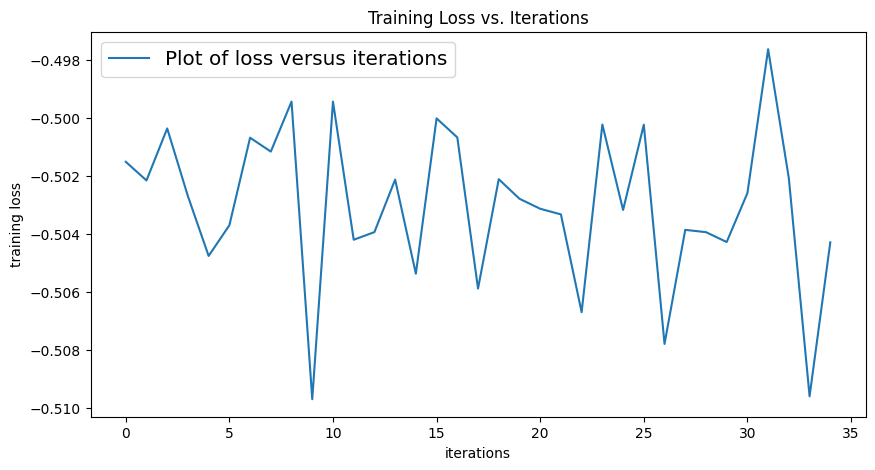

   [i=100]    predicted_label=1       gt_label=1
   [i=200]    predicted_label=1       gt_label=1
   [i=300]    predicted_label=1       gt_label=0
   [i=400]    predicted_label=1       gt_label=0
   [i=500]    predicted_label=1       gt_label=1
   [i=600]    predicted_label=1       gt_label=1
   [i=700]    predicted_label=1       gt_label=1
   [i=800]    predicted_label=1       gt_label=1
   [i=900]    predicted_label=1       gt_label=0
   [i=1000]    predicted_label=1       gt_label=1
   [i=1100]    predicted_label=1       gt_label=0
   [i=1200]    predicted_label=1       gt_label=0
   [i=1300]    predicted_label=1       gt_label=0
   [i=1400]    predicted_label=1       gt_label=1
   [i=1500]    predicted_label=1       gt_label=0
   [i=1600]    predicted_label=1       gt_label=1
   [i=1700]    predicted_label=1       gt_label=1
   [i=1800]    predicted_label=1       gt_label=0

Overall classification accuracy: 52.24%


Number of positive reviews tested: 980


Number of negative review

In [ ]:
run_code_for_training_for_text_classification_with_GRU_word2vec(gru_200,train_dataloader_200, display_train_loss=True)
run_code_for_testing_text_classification_with_GRU_word2vec(gru_200, test_dataloader_200)


[epoch:1  iter:1000  elapsed_time:  94 secs]     loss: -0.50001
[epoch:1  iter:2000  elapsed_time: 186 secs]     loss: -0.50019
[epoch:1  iter:3000  elapsed_time: 280 secs]     loss: -0.49973
[epoch:1  iter:4000  elapsed_time: 370 secs]     loss: -0.50007
[epoch:1  iter:5000  elapsed_time: 461 secs]     loss: -0.49981
[epoch:1  iter:6000  elapsed_time: 556 secs]     loss: -0.50039
[epoch:1  iter:7000  elapsed_time: 659 secs]     loss: -0.50068

[epoch:2  iter:1000  elapsed_time: 794 secs]     loss: -0.49992
[epoch:2  iter:2000  elapsed_time: 891 secs]     loss: -0.50065
[epoch:2  iter:3000  elapsed_time: 988 secs]     loss: -0.50100
[epoch:2  iter:4000  elapsed_time:1080 secs]     loss: -0.50131
[epoch:2  iter:5000  elapsed_time:1175 secs]     loss: -0.49995
[epoch:2  iter:6000  elapsed_time:1268 secs]     loss: -0.50026
[epoch:2  iter:7000  elapsed_time:1362 secs]     loss: -0.50163

[epoch:3  iter:1000  elapsed_time:1499 secs]     loss: -0.50118
[epoch:3  iter:2000  elapsed_time:159

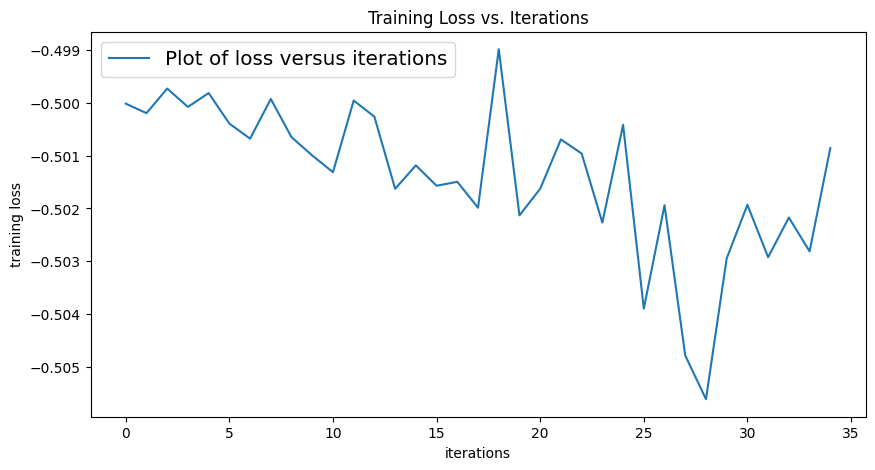

   [i=100]    predicted_label=1       gt_label=1
   [i=200]    predicted_label=1       gt_label=1
   [i=300]    predicted_label=1       gt_label=0
   [i=400]    predicted_label=1       gt_label=0
   [i=500]    predicted_label=1       gt_label=1
   [i=600]    predicted_label=1       gt_label=1
   [i=700]    predicted_label=1       gt_label=1
   [i=800]    predicted_label=1       gt_label=1
   [i=900]    predicted_label=1       gt_label=0
   [i=1000]    predicted_label=1       gt_label=1
   [i=1100]    predicted_label=1       gt_label=0
   [i=1200]    predicted_label=1       gt_label=0
   [i=1300]    predicted_label=1       gt_label=0
   [i=1400]    predicted_label=1       gt_label=1
   [i=1500]    predicted_label=1       gt_label=0
   [i=1600]    predicted_label=1       gt_label=1
   [i=1700]    predicted_label=1       gt_label=1
   [i=1800]    predicted_label=1       gt_label=0

Overall classification accuracy: 52.24%


Number of positive reviews tested: 980


Number of negative review

In [ ]:
run_code_for_training_for_text_classification_with_GRU_word2vec(bi_gru_200,train_dataloader_200, display_train_loss=True)
run_code_for_testing_text_classification_with_GRU_word2vec(bi_gru_200, test_dataloader_200)

In [ ]:
dataserver_train_400 = SentimentAnalysisDataset(
                                 train_or_test = 'train',
                                 dataset_file = dataset_archive_train_200,
                                 path_to_saved_embeddings = path_to_saved_embeddings,
                   )
dataserver_test_400 = SentimentAnalysisDataset(
                                 train_or_test = 'test',
                                 dataset_file = dataset_archive_test_200,
                                 path_to_saved_embeddings = path_to_saved_embeddings,
                  )
train_dataloader_400 = torch.utils.data.DataLoader(dataserver_train_400,
                batch_size=batch_size,shuffle=True, num_workers=2)
test_dataloader_400 = torch.utils.data.DataLoader(dataserver_test_400,
                       batch_size=batch_size,shuffle=False, num_workers=2)

In [ ]:
run_code_for_training_for_text_classification_with_GRU_word2vec(gru_400,train_dataloader_400, display_train_loss=True)
run_code_for_testing_text_classification_with_GRU_word2vec(gru_400, test_dataloader_400)

In [ ]:
run_code_for_training_for_text_classification_with_GRU_word2vec(bi_gru_400,train_dataloader_400, epochs= 5, display_train_loss=True)
run_code_for_testing_text_classification_with_GRU_word2vec(bi_gru_400, test_dataloader_400)